In [1]:
import numpy as np
import xarray as xr
from mpes_tools.Gui_3d import Gui_3d


# import the 3D data
loaded_data= np.load('//nap33/wahada/Phoibospython/scan11443_filtered.npz')

data= xr.DataArray(loaded_data['data_array'], dims=['Angle', 'Ekin','delay'], coords={'Angle': loaded_data['Angle'], 'Ekin': loaded_data['Ekin'],'delay': loaded_data['delay']})   
# data = data.assign_coords(Ekin=data.coords['Ekin'] -21.7)

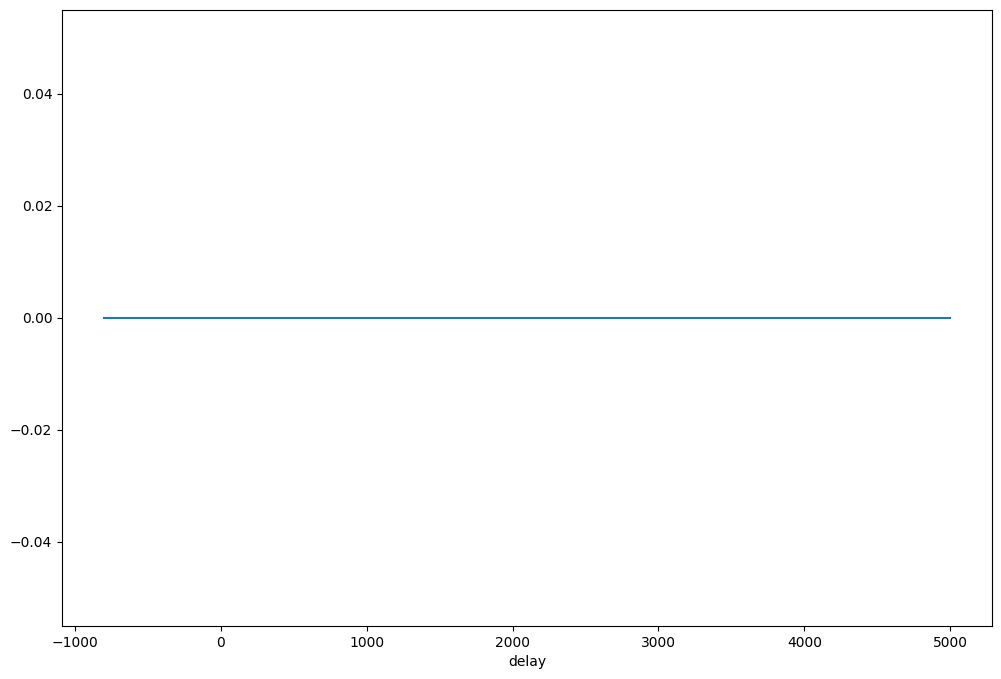

In [2]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(12,8))
data.loc[{data.dims[0]: slice(-3.42, 6.04), data.dims[1]: slice(-0.85, -0.07)}].sum(dim=(data.dims[0], data.dims[1])).plot(ax=ax) 

In [3]:
import xarray as xr

def local_weighted_average_xr(I: xr.DataArray, delta: float, energy_dim='E'):
    """
    Compute F(k,E,t) = (∫ I(k,E',t) E' dE') / (∫ I(k,E',t) dE') 
    using xarray and local integration over energy bounds [E - delta, E + delta].

    Parameters
    ----------
    I : xarray.DataArray
        The input data array with named dims including `energy_dim`.
    delta : float
        Half-width of the energy window around each E.
    energy_dim : str
        The name of the energy axis.

    Returns
    -------
    F : xarray.DataArray
        The computed local weighted average, same dims as input.
    """
    energies = I[energy_dim]
    F = xr.zeros_like(I)

    for E_center in energies:
        E_center_val = E_center.item()
        mask = (energies >= E_center_val - delta) & (energies <= E_center_val + delta)
        
        I_window = I.sel({energy_dim: mask})
        energies_window = energies.sel({energy_dim: mask})

        # numerator: ∫ I(k,E',t) * E' dE'
        num = (I_window * energies_window).sum(dim=energy_dim)
        # denominator: ∫ I(k,E',t) dE'
        den = I_window.sum(dim=energy_dim)

        # Assign back to the corresponding energy slice
        F.loc[{energy_dim: E_center}] = xr.where(den != 0, num / den, 0)

    return F


In [4]:
FM=local_weighted_average_xr(data,delta=0.05,energy_dim='Ekin')
# print(FM['delay'])

In [5]:
FM0=FM.copy()

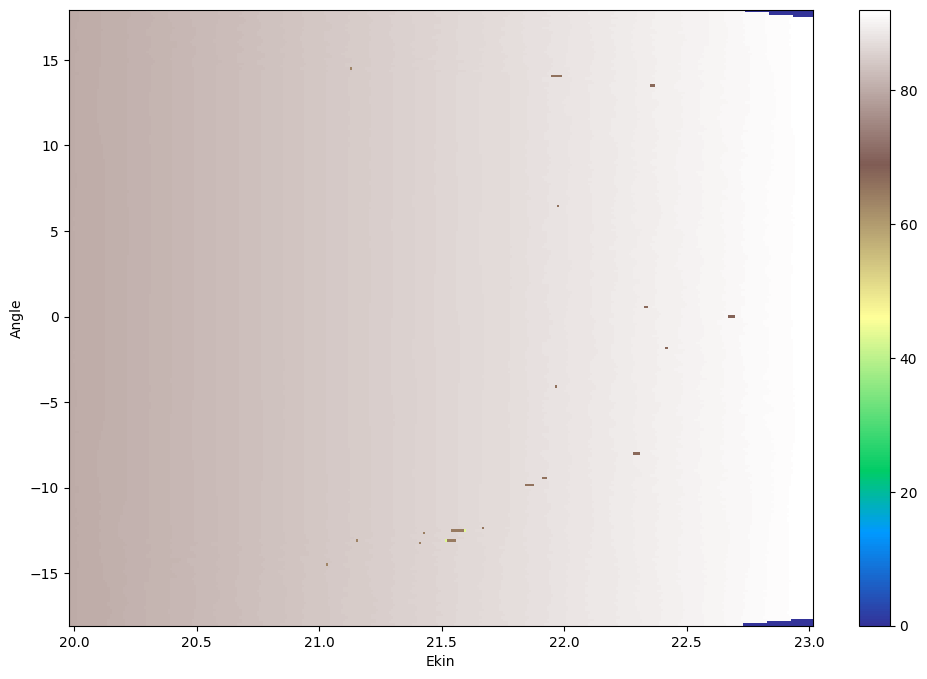

In [6]:
import matplotlib.pyplot as plt

# fig,ax=plt.subplots(1,1,figsize=(12,8))
# data.sel({data.dims[2]:slice(674.5333333333291, 749.4799999999675)}).sum(dim=data.dims[2]).plot(ax=ax, cmap='terrain')
fig,ax=plt.subplots(1,1,figsize=(12,8))
FM.sel({data.dims[2]:slice(674.5333333333291, 749.4799999999675)}).sum(dim=data.dims[2]).plot(ax=ax, cmap='terrain')

In [142]:
from mpes_tools.Gui_3d import Gui_3d
%gui qt

t0=50
data = data.sel(delay=slice(100, None))
# data = data.assign_coords(Ekin=data.coords['Ekin']+21.7)
graph_window= Gui_3d(data,0,0,'Phoibos')
graph_window.show()

('Angle', 'Ekin', 'delay')


In [8]:
FM=data

In [9]:
from scipy.interpolate import interp1d

# Assume your data is F(k, E, t)
# and times is an array with your irregular time points
times_irregular = FM.coords['delay'].values  # for example

# Build regular grid
t_regular = np.linspace(times_irregular.min(), times_irregular.max(), num=82)

# Interpolating along time axis
F_interp = FM.interp(delay=("delay", t_regular))

# Now you can safely FFT along "t"
F_fft = xr.apply_ufunc(
    np.fft.fft,
    F_interp,
    input_core_dims=[["delay"]],
    output_core_dims=[["w"]],
    kwargs={"axis": -1},
    dask="parallelized",
    output_dtypes=[np.complex128]
)

# Generate frequency axis
dt_regular = t_regular[1] - t_regular[0]  # in fs
freqs_thz = np.fft.fftfreq(len(t_regular), dt_regular * 1e-15) / 1e12  # Hz -> THz

# Assign new frequency coordinate
F_fft = F_fft.assign_coords(w=("w", freqs_thz))

In [10]:
from mpes_tools.Gui_3d import Gui_3d
%gui qt
# FM = FM.assign_coords(Ekin=data.coords['Ekin'] +21.7)
graph_window= Gui_3d(np.real(F_fft),0,0,'Phoibos')
graph_window.show()

('Angle', 'Ekin', 'w')


In [11]:
from mpes_tools.Gui_3d import Gui_3d
%gui qt
# FM = FM.assign_coords(Ekin=data.coords['Ekin'] +21.7)
graph_window= Gui_3d(abs(F_fft),0,0,'Phoibos')
graph_window.show()

('Angle', 'Ekin', 'w')


In [12]:
data1

<xarray.DataArray (Angle: 256, Ekin: 344, w: 82)> Size: 58MB
array([[[ 4.51142365e+00,  5.47494129e-01,  4.42183868e-02, ...,
          6.90190302e-01,  4.42183868e-02,  5.47494129e-01],
        [ 9.70199908e+00,  3.34041252e-01, -2.37147789e-01, ...,
          8.18496316e-01, -2.37147789e-01,  3.34041252e-01],
        [ 2.01537330e+01,  2.75557828e-01, -6.21352380e-03, ...,
          4.82574220e-01, -6.21352380e-03,  2.75557828e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 5.62276254e+00,  3.75256398e-01,  9.96360625e-02, ...,
          5.70264868e-01,  9.96360625e-02,  3.75256398e-01],
        [ 9.08316421e+00,  4.46402356e-01, -3.77576523e-01, ...,
          9.44135612e-01, -3.77576523e-01,  4.46402356e-01],
        [ 2.08768319e+01,  2.03925670e-01, -1.85723886e-01, ...,
          7.15182955e-01, -1.85723886e-01,  2.03925670e-01],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 3.22916016e+01,  4.67897519e+00, -5.94371533e+00, ...,
         -3.26991699e+00, -5.94371533e+00,  4.67897519e+00],
        [ 4.65818644e+01,  6.93022988e+00, -6.28373484e+00, ...,
         -7.14805054e+00, -6.28373484e+00,  6.93022988e+00],
        [ 5.84768152e+01,  1.19505652e+01, -1.23058021e+01, ...,
         -7.26972754e+00, -1.23058021e+01,  1.19505652e+01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * Angle    (Angle) float64 2kB -18.0 -17.86 -17.72 ... 17.58 17.72 17.86
  * Ekin     (Ekin) float64 3kB 19.98 19.99 20.0 20.01 ... 22.99 23.0 23.01
  * w        (w) float64 656B 0.0 0.2028 0.4055 ... -0.6083 -0.4055 -0.2028

In [16]:
data1=np.real(F_fft)
data1 = data1.assign_coords(Ekin=data.coords['Ekin'] -21.7)
box=data1.loc[{data1.dims[0]: slice(3.836923121521334, 7.287758000927639), data1.dims[1]: slice(0.04673711789464763, 0.21682616666506682)}].mean(dim=(data1.dims[0], data1.dims[1]))

(0.0, 200000.0)

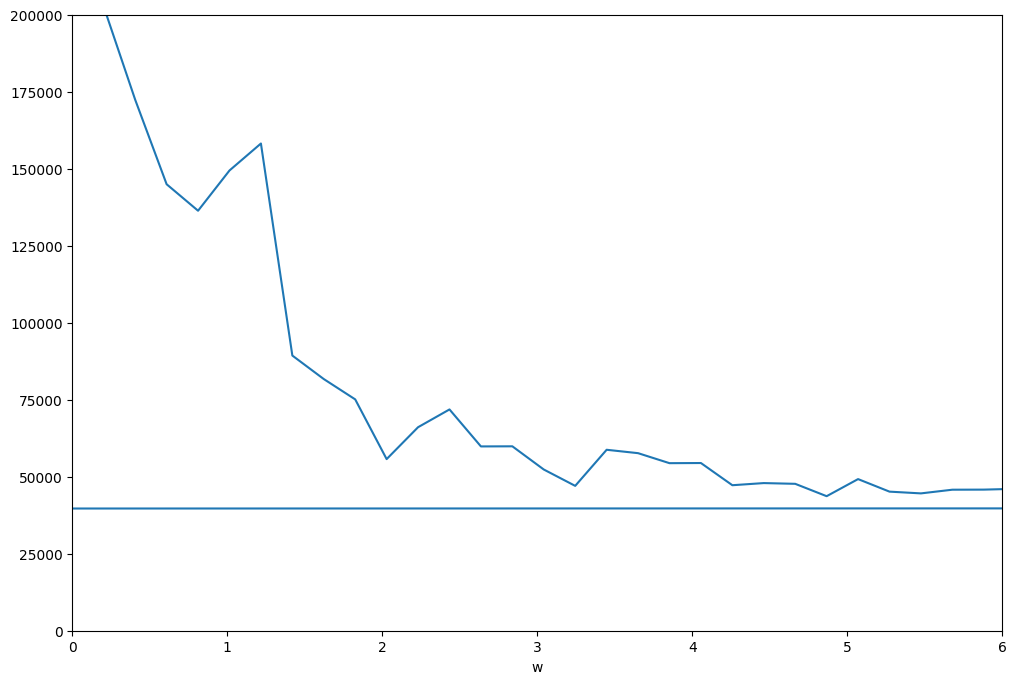

In [20]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(12,8))
box.plot(ax=ax) 
ax.set_xlim(0,6)
ax.set_ylim(0,2e5)

In [9]:
import numpy as np
import xarray as xr

def remove_background_polynomial(F, degree=2, time_dim="delay"):
    """Remove low-frequency background by polynomial fitting at each (k,E) pixel."""
    def fit_and_subtract(y, t):
        coeffs = np.polyfit(t, y, degree)
        background = np.polyval(coeffs, t)
        return y - background
    
    t = F[time_dim].values
    
    # Apply along the time axis
    detrended = xr.apply_ufunc(
        fit_and_subtract,
        F,
        t,
        input_core_dims=[[time_dim], [time_dim]],
        output_core_dims=[[time_dim]],
        vectorize=True
    )
    
    return detrended

In [13]:
data2=remove_background_polynomial(data,3,'delay')

In [15]:
from mpes_tools.Gui_3d import Gui_3d
%gui qt

# t0=50
# data = data.sel(delay=slice(100, None))
# data = data.assign_coords(Ekin=data.coords['Ekin']+21.7)
graph_window= Gui_3d(data2,0,0,'Phoibos')
graph_window.show()

('Angle', 'Ekin', 'delay')


In [17]:
from scipy.interpolate import interp1d
def fourier_data(FM):
    # Assume your data is F(k, E, t)
    # and times is an array with your irregular time points
    times_irregular = FM.coords['delay'].values  # for example

    # Build regular grid
    t_regular = np.linspace(times_irregular.min(), times_irregular.max(), num=82)

    # Interpolating along time axis
    F_interp = FM.interp(delay=("delay", t_regular))

    # Now you can safely FFT along "t"
    F_fft = xr.apply_ufunc(
        np.fft.fft,
        F_interp,
        input_core_dims=[["delay"]],
        output_core_dims=[["w"]],
        kwargs={"axis": -1},
        dask="parallelized",
        output_dtypes=[np.complex128]
    )

    # Generate frequency axis
    dt_regular = t_regular[1] - t_regular[0]  # in fs
    freqs_thz = np.fft.fftfreq(len(t_regular), dt_regular * 1e-15) / 1e12  # Hz -> THz

    # Assign new frequency coordinate
    F_fft = F_fft.assign_coords(w=("w", freqs_thz))
    return F_fft

In [18]:
from mpes_tools.Gui_3d_v2 import Gui_3d
%gui qt
# FM = FM.assign_coords(Ekin=data.coords['Ekin'] +21.7)
graph_window= Gui_3d(fourier_data(data2).real,0,0,'Phoibos')
graph_window.show()

('Angle', 'Ekin', 'w')


In [19]:
from mpes_tools.Gui_3d_v2 import Gui_3d
%gui qt
# FM = FM.assign_coords(Ekin=data.coords['Ekin'] +21.7)
graph_window= Gui_3d(abs(fourier_data(data2)),0,0,'Phoibos')
graph_window.show()

('Angle', 'Ekin', 'w')


In [20]:
from scipy.ndimage import gaussian_filter1d

def remove_background_gaussian(F, sigma=5, time_dim="t"):
    """Remove background using a Gaussian filter along time."""
    def smooth_and_subtract(y):
        smooth = gaussian_filter1d(y, sigma)
        return y - smooth

    detrended = xr.apply_ufunc(
        smooth_and_subtract,
        F,
        input_core_dims=[[time_dim]],
        output_core_dims=[[time_dim]],
        vectorize=True
    )
    
    return detrended

In [143]:
data3=remove_background_gaussian(data,5,'delay')
# data3=remove_background_gaussian(data3,5,'delay')
# data3=remove_background_gaussian(data3,5,'delay')
# data3=remove_background_gaussian(data3,5,'delay')

In [144]:
from scipy.signal import windows
t = data3["delay"].values
window = windows.hann(len(t))
def prepare_for_fft(y):
    y = y - np.nanmean(y)  # remove mean
    y = y * window         # apply window
    return y

data3 = xr.apply_ufunc(
    prepare_for_fft,
    data3,
    input_core_dims=[["delay"]],
    output_core_dims=[["delay"]],
    vectorize=True
)


In [50]:
from mpes_tools.Gui_3d import Gui_3d
%gui qt

# t0=50
# data = data.sel(delay=slice(100, None))
# data = data.assign_coords(Ekin=data.coords['Ekin']+21.7)
graph_window= Gui_3d(data3,0,0,'Phoibos')
graph_window.show()

('Angle', 'Ekin', 'delay')
0.0 1.0


In [141]:
from mpes_tools.Gui_3d_v2 import Gui_3d
%gui qt
# FM = FM.assign_coords(Ekin=data.coords['Ekin'] +21.7)
graph_window= Gui_3d(abs(fourier_data(data3)),0,0,'Phoibos')

graph_window.show()

('Angle', 'Ekin', 'w')


In [155]:
from mpes_tools.Gui_3d_v2 import Gui_3d
%gui qt
# FM = FM.assign_coords(Ekin=data.coords['Ekin'] +21.7)
graph_window= Gui_3d(fourier_data(data3).real,0,0,'Phoibos')

graph_window.show()

('Angle', 'Ekin', 'w')


In [33]:
data_avg= data.sum(dim="delay")

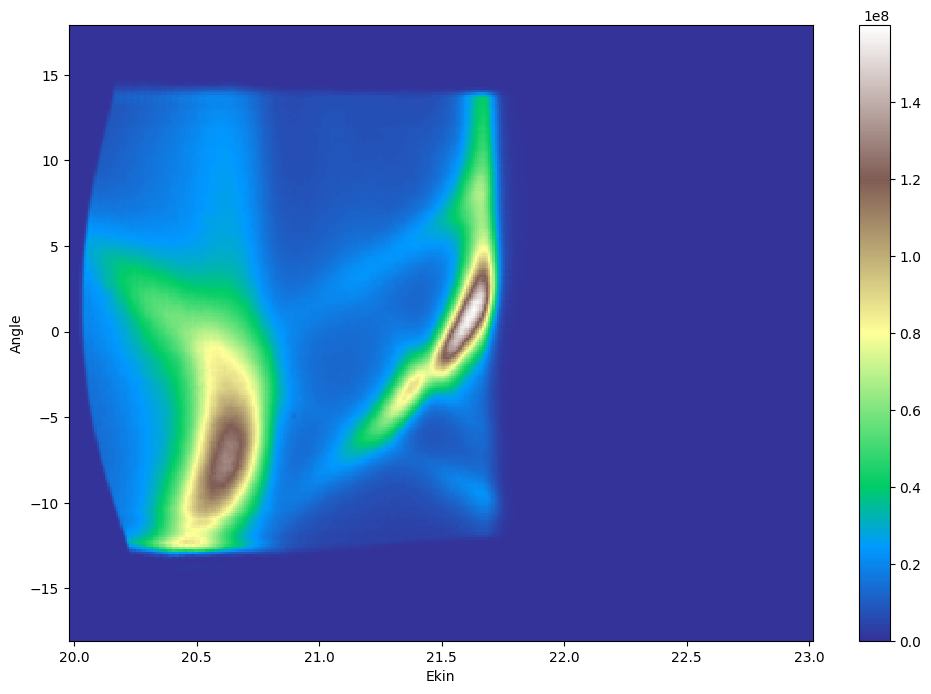

In [34]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,1,figsize=(12,8))
data_avg.plot(ax=ax, cmap='terrain')

In [35]:
import xarray as xr
import numpy as np

def compute_curvature(I: xr.DataArray, C_E: float = 1.0) -> xr.DataArray:
    # Ensure dimensions are ordered and named correctly
    if I.dims != ('Angle', 'Ekin'):
        raise ValueError("Expected dimensions ('Angle', 'Ekin'), got: {}".format(I.dims))
    
    dk = float(I['Angle'][1] - I['Angle'][0])
    dE = float(I['Ekin'][1] - I['Ekin'][0])
    
    # Ck from given formula
    C_k = (dk / dE) ** 2 * C_E

    # First derivatives
    dI_dk = I.differentiate('Angle')
    dI_dE = I.differentiate('Ekin')
    
    # Second derivatives
    d2I_dk2 = dI_dk.differentiate('Angle')
    d2I_dE2 = dI_dE.differentiate('Ekin')
    d2I_dk_dE = dI_dk.differentiate('Ekin')  # or dI_dE.differentiate('k')

    # Numerator
    numerator = (dI_dk**2) * d2I_dE2 - 2 * dI_dk * dI_dE * d2I_dk_dE + (dI_dE**2) * d2I_dk2

    # Denominator
    denominator = (C_k * (dI_dk**2) + C_E * (dI_dE**2)) ** 1.5

    # Avoid division by zero
    denominator = xr.where(denominator == 0, np.nan, denominator)

    # Final curvature
    curvature = numerator / denominator

    return curvature


In [38]:
curvature=compute_curvature(data_avg)

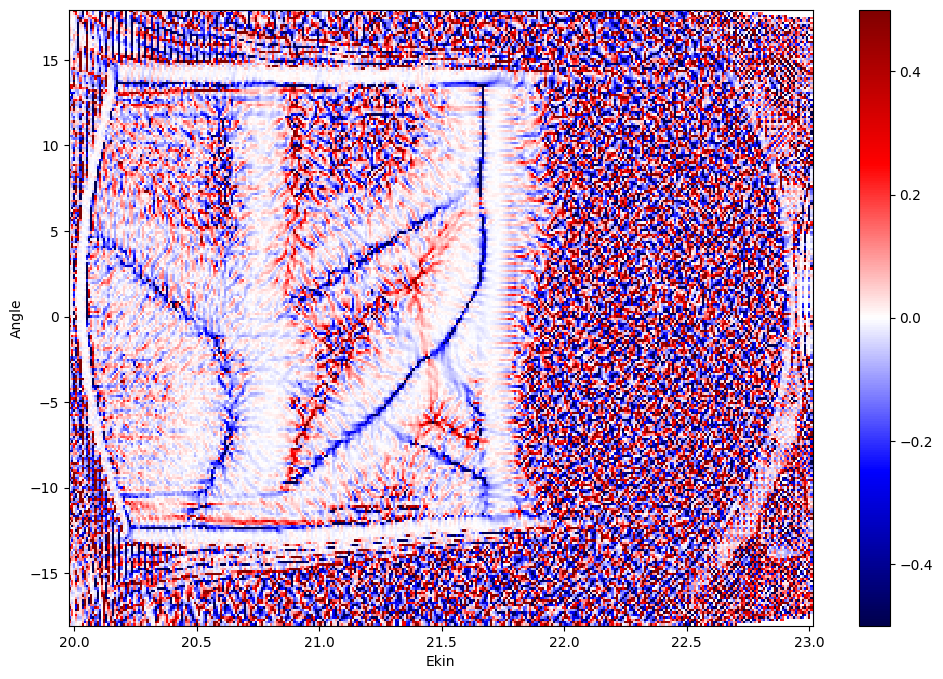

In [46]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,1,figsize=(12,8))
im=curvature.plot(ax=ax, cmap='seismic')
im.set_clim(-0.5, 0.5)

AttributeError: 'list' object has no attribute 'set_clim'

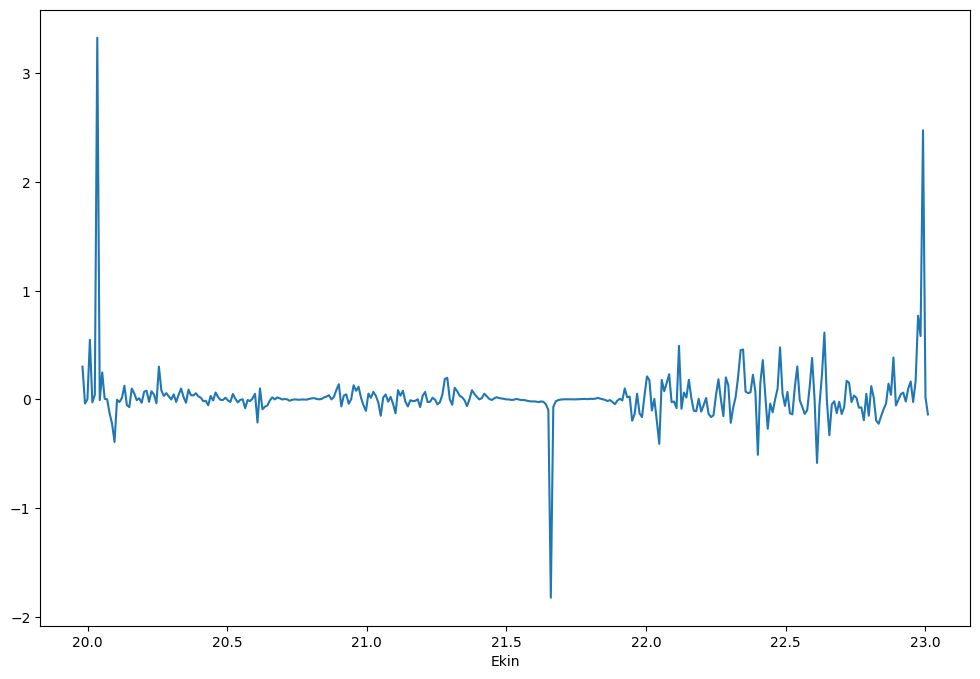

In [45]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
im=curvature.sel({'Angle':slice(7,9)}).mean(dim="Angle").plot(ax=ax)
im.set_clim(-1, 1)

In [84]:
%matplotlib qt 
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,1,figsize=(12,8))
im=abs(curvature).plot(ax=ax, cmap='seismic')
im.set_clim(0, 1)

In [68]:
%matplotlib qt 
import matplotlib.pyplot as plt
import numpy as np
import mplcursors

data = np.random.rand(100, 200)
fig, ax = plt.subplots()
im = ax.imshow(data, origin='lower', aspect='auto')

# Add interactive cursor
cursor = mplcursors.cursor(im, hover=True)
@cursor.connect("add")
def on_add(sel):
    i, j = int(sel.target.index[0]), int(sel.target.index[1])
    sel.annotation.set_text(f"({j}, {i}) = {data[i, j]:.3f}")

plt.show()


Traceback (most recent call last):
  File "c:\Program Files\Python312\Lib\site-packages\matplotlib\cbook.py", line 361, in process
    func(*args, **kwargs)
  File "c:\Program Files\Python312\Lib\site-packages\mplcursors\_mplcursors.py", line 580, in _on_hover_motion_notify
    self._on_select_event(event)
  File "c:\Program Files\Python312\Lib\site-packages\mplcursors\_mplcursors.py", line 628, in _on_select_event
    self.add_selection(pi)
  File "c:\Program Files\Python312\Lib\site-packages\mplcursors\_mplcursors.py", line 411, in add_selection
    cb(sel)
  File "C:\Users\wahada\AppData\Local\Temp\ipykernel_18684\1531230737.py", line 14, in on_add
    i, j = int(sel.target.index[0]), int(sel.target.index[1])
               ^^^^^^^^^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'index'
Traceback (most recent call last):
  File "c:\Program Files\Python312\Lib\site-packages\matplotlib\cbook.py", line 361, in process
    func(*args, **kwargs)
  File "c:\Program Files\

In [17]:
import xarray as xr
import numpy as np

def compute_curvature2(I: xr.DataArray, C_E: float = 1.0) -> xr.DataArray:
    # Ensure dimensions are ordered and named correctly
    # if I.dims != ('Angle', 'Ekin'):
    #     raise ValueError("Expected dimensions ('Angle', 'Ekin'), got: {}".format(I.dims))
    
    dk = float(I['Angle'][1] - I['Angle'][0])
    dE = float(I['Ekin'][1] - I['Ekin'][0])
    
    # Ck from given formula
    C_k = (dk / dE) ** 2 * C_E
    print(C_k)
    # First derivatives
    dI_dk = I.differentiate('Angle')
    dI_dE = I.differentiate('Ekin')
    
    # Second derivatives
    d2I_dk2 = dI_dk.differentiate('Angle')
    d2I_dE2 = dI_dE.differentiate('Ekin')
    d2I_dk_dE = dI_dk.differentiate('Ekin')  # or dI_dE.differentiate('k')

    # Numerator
    numerator = (1+ C_k*(dI_dk**2)) * d2I_dE2 - 2* C_k * dI_dk * dI_dE * d2I_dk_dE + (1+(dI_dE**2)) *C_k* d2I_dk2

    # Denominator
    denominator = (1+C_k * (dI_dk**2) + C_E * (dI_dE**2)) ** 1.5

    # Avoid division by zero
    denominator = xr.where(denominator == 0, np.nan, denominator)

    # Final curvature
    curvature = numerator / denominator

    return curvature


In [92]:
%matplotlib qt 
import matplotlib.pyplot as plt
curvature2=compute_curvature2(data_avg)
fig,ax=plt.subplots(1,1,figsize=(12,8))
im=abs(curvature2).plot(ax=ax, cmap='seismic')
im.set_clim(100, 200)

In [101]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,1,figsize=(12,8))
im=curvature2.plot(ax=ax, cmap='seismic')
im.set_clim(-150, 150)

In [129]:
from scipy.ndimage import gaussian_filter
I=curvature2
I_smooth = xr.DataArray(
    gaussian_filter(I.values, sigma=(5, 5)),  # tune sigma
    dims=I.dims,
    coords=I.coords
)
fig,ax=plt.subplots(1,1,figsize=(12,8))
im=I_smooth.plot(ax=ax, cmap='seismic')
im.set_clim(-150, 150)

In [115]:
threshold = 1e7
data_avg_mask=data_avg.where(data_avg >= threshold)

In [149]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
im=data_avg_mask.plot(ax=ax, cmap='seismic')

In [150]:
import matplotlib.pyplot as plt
curvature3= compute_curvature2(data_avg_mask).fillna(0)
curvature3 = curvature3.assign_coords(Ekin=curvature3.coords['Ekin'] -21.7)
fig,ax=plt.subplots(1,1,figsize=(12,8))
im=curvature3.plot(ax=ax, cmap='seismic')
im.set_clim(-150, 150)

In [131]:
curvature3

<xarray.DataArray (Angle: 256, Ekin: 344)> Size: 705kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * Angle    (Angle) float64 2kB -18.0 -17.86 -17.72 ... 17.58 17.72 17.86
  * Ekin     (Ekin) float64 3kB 19.98 19.99 20.0 20.01 ... 22.99 23.0 23.01

In [ ]:
from mpes_tools.Gui_3d_v2 import Gui_3d
%gui qt
# FM = FM.assign_coords(Ekin=data.coords['Ekin'] +21.7)
plot=fourier_data(data3).real*curvature3
# plot=fourier_data(data3).real
graph_window= Gui_3d(plot,0,0,'Phoibos')

graph_window.show()

('Angle', 'Ekin', 'w')


Traceback (most recent call last):
  File "c:\Program Files\Python312\Lib\site-packages\matplotlib\cbook.py", line 361, in process
    func(*args, **kwargs)
  File "C:\Users\wahada\Desktop\mpes-tools\src\mpes_tools\cursor_handler.py", line 24, in on_motion
    self.changes()
  File "C:\Users\wahada\Desktop\mpes-tools\src\mpes_tools\Gui_3d_v2.py", line 247, in <lambda>
    self.cursors_functions=[lambda:  self.changes_cursor_vertical_1(),lambda: self.changes_cursor_horizontal_1(), lambda: self.changes_cursor_vertical_2(),lambda: self.changes_cursor_horizontal_2()]
                                                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\wahada\Desktop\mpes-tools\src\mpes_tools\Gui_3d_v2.py", line 273, in changes_cursor_horizontal_1
    self.box()
  File "C:\Users\wahada\Desktop\mpes-tools\src\mpes_tools\Gui_3d_v2.py", line 539, in box
    self.axes[3].set_ylim(1.2*self.int.data[4:-1].min(),1.2*self.int.data[4:-1].max())
  File "c:\

In [135]:
data

array([[0.93940164, 0.7217795 , 0.19723724, ..., 0.73367041, 0.08395667,
        0.47304524],
       [0.70615428, 0.7284048 , 0.06604852, ..., 0.24461794, 0.07940214,
        0.44932863],
       [0.48379558, 0.78348808, 0.45152709, ..., 0.3692468 , 0.57510612,
        0.11366133],
       ...,
       [0.09597949, 0.23376572, 0.9136176 , ..., 0.95918848, 0.06900845,
        0.85886626],
       [0.44720414, 0.20937698, 0.50395826, ..., 0.87816451, 0.59429412,
        0.14343085],
       [0.96031516, 0.4876951 , 0.7216181 , ..., 0.80339147, 0.55495315,
        0.06462377]])

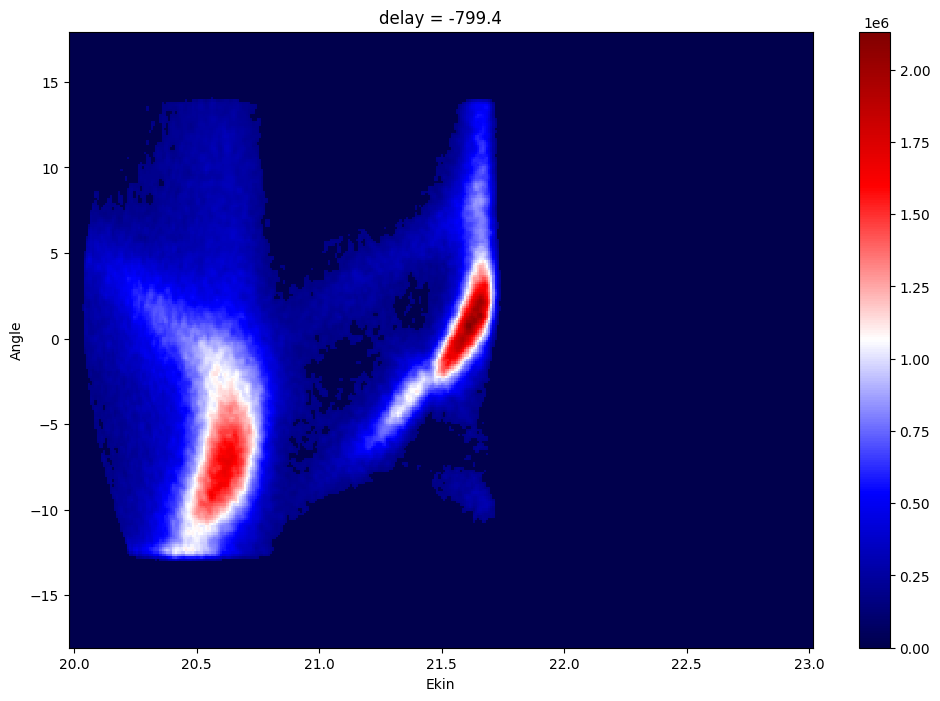

In [26]:
threshold = 1.7e5
data_cut=data.where(data >= threshold).fillna(0)
fig, ax = plt.subplots(figsize=(12, 8))
im = data_cut.isel({dims[2]: 0}).plot(ax=ax, cmap='seismic')
# im.set_clim(-150, 150)

In [27]:
data_curv= compute_curvature2(data_cut)
# data_curv= compute_curvature(data)

253.88580609754177


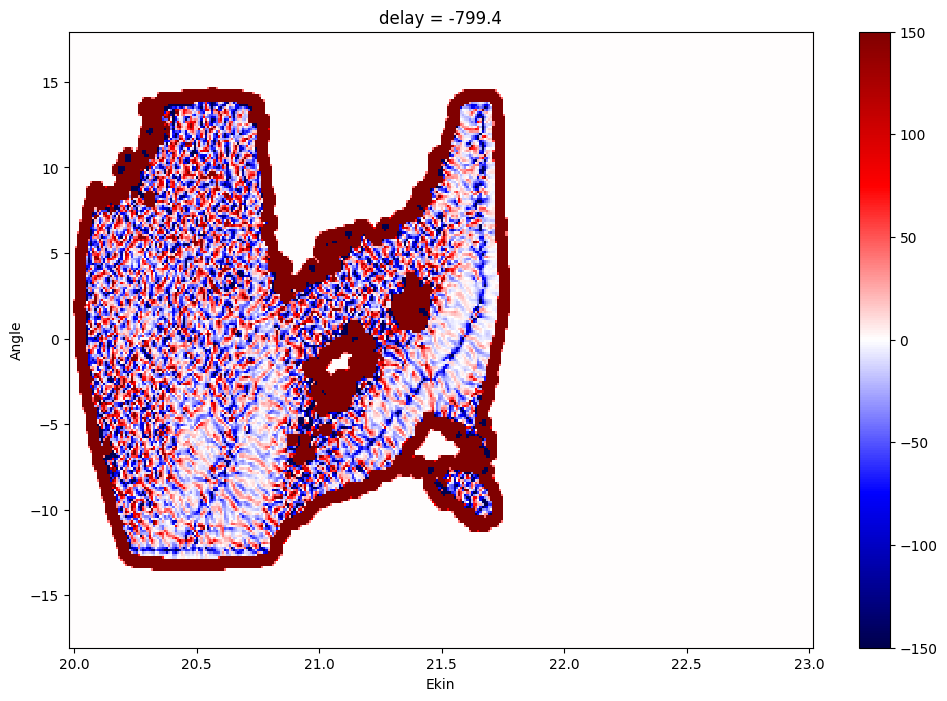

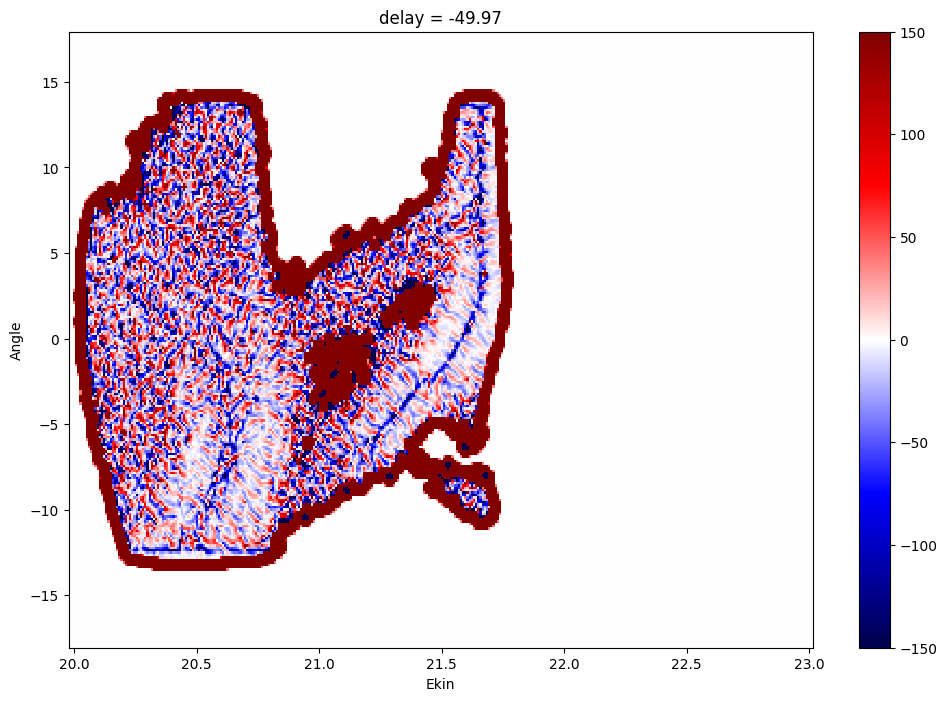

In [28]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
# Assume you want to smooth over dims 0 and 1, not dim 2
smooth_dims = (0.5, .5)  # sigma for the first two dims

# Get dimension names
dims = data_curv.dims
coord_names = data_curv.coords

# Apply smoothing along slices of the third dimension
smoothed_vals = np.stack([
    gaussian_filter(data_curv.isel({dims[2]: i}).values, sigma=smooth_dims)
    for i in range(data_curv.sizes[dims[2]])
], axis=2)

# Create a new DataArray from smoothed values
I_smooth = xr.DataArray(
    smoothed_vals,
    dims=dims,
    coords={dim: data_curv.coords[dim] for dim in dims}
)

# Plot one slice as example
fig, ax = plt.subplots(figsize=(12, 8))
im = I_smooth.isel({dims[2]: 0}).plot(ax=ax, cmap='seismic')
im.set_clim(-150, 150)
fig, ax = plt.subplots(figsize=(12, 8))
im = I_smooth.isel({dims[2]: 5}).plot(ax=ax, cmap='seismic')
im.set_clim(-150, 150)


In [32]:
from mpes_tools.Gui_3d import Gui_3d
%gui qt

graph_window= Gui_3d(I_smooth,0,0,'Phoibos')
graph_window.show()

('Angle', 'Ekin', 'delay')


TypeError: rangeChanged(self, min: int, max: int).emit(): argument 2 has unexpected type 'int'